In [59]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
papers = pd.read_csv('datasets/ai_papers_00-17.csv')
papers.shape

(18145, 5)

In [61]:
papers.head()

,paper_title,num_of_citations,conference,year,is_link
0,Value ordering for finding all solutions,44,IJCAI,2005,True
1,A Conceptual Graph Approach for the Generation...,31,IJCAI,2007,True
2,Exploiting image contents in web search,34,IJCAI,2007,True
3,Best-First Utility-Guided Search,31,IJCAI,2007,True
4,Ambiguous part-of-speech tagging for improving...,30,IJCAI,2007,True


In [62]:
papers.describe()

,num_of_citations,year
count,18145.000000,18145.000000
mean,41.096335,2010.491265
std,168.956386,5.005128
min,0.000000,2000.000000
25%,3.000000,2007.000000
50%,10.000000,2011.000000
75%,32.000000,2015.000000
max,9432.000000,2017.000000


In [63]:
# papers.nlargest(10, 'num_of_citations')

In [64]:
CUT_OFF = papers['num_of_citations'].median()
print(f"Median is {CUT_OFF}")
CUT_OFF = int(CUT_OFF)
# CUT_OFF = 15
print(f"Cut off used is {CUT_OFF}")

Median is 10.0
Cut off used is 10


In [65]:
papers['target'] = papers['num_of_citations'].apply(lambda x: True if x >= CUT_OFF else False)

In [66]:
num_true = len(papers[papers['target'] == True])
print(f"True paper titles are: {num_true}")
num_false = len(papers[papers['target'] == False])
print(f"False paper titles are: {num_false}")

True paper titles are: 9460
False paper titles are: 8685


In [67]:
## Look at the good papers
# for i, row in papers.iterrows():
#     if (row['num_of_citations'] > CUT_OFF):
#         print(row['paper_title'])
#         print(row['num_of_citations'])
#         print('\n')

## Feature extraction

In [68]:
# import spacy
from spacy_download import load_spacy
nlp = load_spacy('en_core_web_lg') # nlp = spacy.load('en') # nlp = load_spacy('en_core_web_lg')
substantives_pos = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB']
key_words = ["machine", "learning", "system", "artificial", "intelligence"]

def process_title(title):
    data_pt = {}
    data_pt['paper_title'] = title
    
    # uppercase word
    words = title.split()
    has_uppercase_word = False
    for word in words:
        if word.isupper() == True and len(word) > 2:
            has_uppercase_word = True
            break
    
    title = title.lower()
    data_pt['num_of_chars'] = len(title)

    data_pt['num_of_words'] = len(words)
    # has something
    data_pt['has_comma'] = True if "," in title else False
    has_colon = True if ":" in title else False
    data_pt['has_colon'] = has_colon
    data_pt['has_hyphen'] = True if "-" in title else False
    data_pt['has_!'] = True if "!" in title else False
    data_pt['has_?'] = True if "?" in title else False
    boolean_list = [True for key_word in key_words if key_word in title]
#     data_pt['ai_paper'] = True if True in boolean_list else False
    data_pt['has_uppercase_word'] = has_uppercase_word
        
    # POS features
    text_before_colon = title.split(":")[0] if has_colon == True else ""
    words_before_colon = nlp(text_before_colon)
    tokens = nlp(title)
    left_colon_tokens = nlp(text_before_colon)
    verbs = []
    determinants = []
    nouns = []
    out_dict_words = []
    out_dict_words_before_colon = []
    substantives = []
    for i, token in enumerate(tokens):
        if token.pos_ in substantives_pos:
            substantives.append(token)
        if token.pos_ in ['AUX', 'VERB']:
            verbs.append(token)
        elif token.pos_  == 'NOUN':
            nouns.append(token)
        elif token.pos_ == 'DET':
            determinants.append(token)    
        if token.is_oov:
            out_dict_words.append(token)
            if i < len(left_colon_tokens):
                out_dict_words_before_colon.append(token)
    al_num = [char for char in title if char != ' ' if char.isalpha() == False]

#     data_pt['has_non_al_num'] = True if len(al_num) > 0 else False
    data_pt['num_out_dict_words'] = len(out_dict_words)
    data_pt['num_right_out_dict_words'] = len(out_dict_words) - len(out_dict_words_before_colon)
    data_pt['share_verbs'] = len(verbs)/len(tokens)
    data_pt['share_nouns'] = len(nouns)/len(tokens)
    data_pt['share_dets'] = len(determinants)/len(tokens)
    data_pt['share_out_dict_words'] = len(out_dict_words)/len(tokens)
    data_pt['share_left_colon_words'] = len(words_before_colon)/len(tokens)    
    data_pt['share_substantives'] = len(substantives)/len(tokens)
    data_pt['share_non_al_num'] = len(al_num)/len(title)
#     print(data_pt)
    return data_pt, words

In [69]:
# titles = [
#     "The application of Computational Creativity evaluation methods to art and music-based systems",
#     "Generation or Creativity erlje",
#     "Therapeutic Computational Creativity",
#     "The compusss willey return too good matttere rendr",
#     "Human-Computer Evaluation: Inverting the co-creative paradigm",
# ]

# # random forest evaluator
# for title in titles:
#     process_title(title)

In [70]:
# build the data target for classification
data = []
for i, row in papers.iterrows():
    data_pt = process_title(row['paper_title'])[0]
    data_pt['target'] = row['target']
    data.append(data_pt)
titles_df = pd.DataFrame(data)

## EDA

In [71]:
# [titles_df['%_dets'] > 0]

In [72]:
def true_false(df):
    true_df = df[df['target'] == True]
    false_df = df[df['target'] == False]
    return true_df, false_df

In [73]:
true_df, false_df = true_false(titles_df)
mean_num_chars_true = true_df['num_of_chars'].mean()
mean_num_chars_false = false_df['num_of_chars'].mean()
print(f"Mean character value for True target: {mean_num_chars_true}")
print(f"Mean character value for False target: {mean_num_chars_false}")

Mean character value for True target: 63.572832980972514
Mean character value for False target: 65.3986183074266


In [74]:
GOOD_PAPER_LENGTH = np.ceil(mean_num_chars_true)
print(GOOD_PAPER_LENGTH)
GOOD_PAPER_LENGTH = 71

64.0


In [75]:
has_colon_df = titles_df[titles_df['has_colon'] == True]
print(f"Length has_colon: {len(has_colon_df)}")

has_colon_true_df, has_colon_false_df = true_false(has_colon_df)
print(f"True has_colon: {len(has_colon_true_df)}")
print(f"False has_colon: {len(has_colon_false_df)}")
len(has_colon_df)/len(titles_df)
has_colon_true_df, has_colon_false_df = true_false(has_colon_df)
has_colon_true_df['num_of_chars'].mean()

Length has_colon: 3456
True has_colon: 1842
False has_colon: 1614


76.37622149837134

In [76]:
has_colon_good_df = has_colon_df[has_colon_df['share_left_colon_words'] < 0.5]
print(f"Length left part less than 0.5: {len(has_colon_good_df)}")

has_colon_good_true_df, has_colon_good_false_df = true_false(has_colon_good_df)
print(f"True good has_colon: {len(has_colon_good_true_df)}")
print(f"False good has_colon: {len(has_colon_good_false_df)}")

Length left part less than 0.5: 2719
True good has_colon: 1484
False good has_colon: 1235


In [77]:
print(f"Percentage of left part less than 0.5: {100*len(has_colon_good_df)/len(has_colon_df)}")
print(f"Percentage of GOOD left part less than 0.5: {100*len(has_colon_good_true_df)/len(has_colon_good_df)}")

Percentage of left part less than 0.5: 78.67476851851852
Percentage of GOOD left part less than 0.5: 54.57888929753586


In [78]:
has_colon_df['num_of_chars'].mean()

77.39699074074075

In [79]:
has_colon_true_df['num_of_chars'].mean()

76.37622149837134

In [80]:
has_colon_false_df['num_of_chars'].mean()

78.56195786864932

In [81]:
def is_good_short_title(words):
    first_letters, last_letters = [], []
    for i in range(len(words)):
        first_letters.append(words[i][0])
        last_letters.append(words[i][-1])
    max_first_letters_count = 0
    for i, letter in enumerate(first_letters):
        first_letters_count = first_letters.count(first_letters[i][0])
        if first_letters_count > max_first_letters_count:
            max_first_letters_count = first_letters_count
    max_last_letters_count = 0
    for i, letter in enumerate(last_letters):
        last_letters_count = last_letters.count(last_letters[i][-1])
        if last_letters_count > max_last_letters_count:
            max_last_letters_count = last_letters_count
    if max_first_letters_count <  2 and max_last_letters_count < 2:
        is_good = False
    else:
        is_good = True
    return is_good

In [82]:
def find_num_poetic_titles(df):
    num_poetic_short_title = 0
    for index, short_title in df.iterrows():
        data, words = process_title(short_title['paper_title'])
        if is_good_short_title(words) == True:
            num_poetic_short_title += 1
    return num_poetic_short_title

In [83]:
short_titles_df = titles_df[titles_df['num_of_words'] < 5]
print(f"Short number of words: {len(short_titles_df)}\n")

short_titles_true_df, short_titles_false_df = true_false(short_titles_df)
print(f"True percentage of short titles: {len(short_titles_true_df)/len(short_titles_df)}")
print(f"False percentage of short titles: {len(short_titles_false_df)/len(short_titles_df)}\n")

num_poetic_in_true = find_num_poetic_titles(short_titles_true_df)
num_poetic_in_false = find_num_poetic_titles(short_titles_false_df)
print(f"True percentage of poetic titles: {num_poetic_in_true/len(short_titles_df)}")
print(f"False percentage of poetic titles: {num_poetic_in_false/len(short_titles_df)}")

Short number of words: 1414

True percentage of short titles: 0.5502121640735502
False percentage of short titles: 0.4497878359264498

True percentage of poetic titles: 0.20226308345120225
False percentage of poetic titles: 0.16973125884016974


## Training and test sets

In [84]:
y = titles_df['target']
X_with_title = titles_df.drop(['target'], axis=1)
X_with_title.head()

,paper_title,num_of_chars,num_of_words,has_comma,has_colon,has_hyphen,has_!,has_?,has_uppercase_word,num_out_dict_words,num_right_out_dict_words,share_verbs,share_nouns,share_dets,share_out_dict_words,share_left_colon_words,share_substantives,share_non_al_num
0,Value ordering for finding all solutions,40,6,False,False,False,False,False,False,0,0,0.333333,0.333333,0.166667,0.0,0.0,0.666667,0.000000
1,A Conceptual Graph Approach for the Generation...,71,10,False,False,False,False,False,False,0,0,0.100000,0.400000,0.200000,0.0,0.0,0.600000,0.000000
2,Exploiting image contents in web search,39,6,False,False,False,False,False,False,0,0,0.166667,0.666667,0.000000,0.0,0.0,0.833333,0.000000
3,Best-First Utility-Guided Search,32,3,False,False,True,False,False,False,0,0,0.142857,0.285714,0.000000,0.0,0.0,0.714286,0.062500
4,Ambiguous part-of-speech tagging for improving...,99,12,False,False,True,False,False,False,0,0,0.062500,0.437500,0.000000,0.0,0.0,0.625000,0.020202


In [85]:
X = X_with_title.drop(['paper_title'], axis=1)

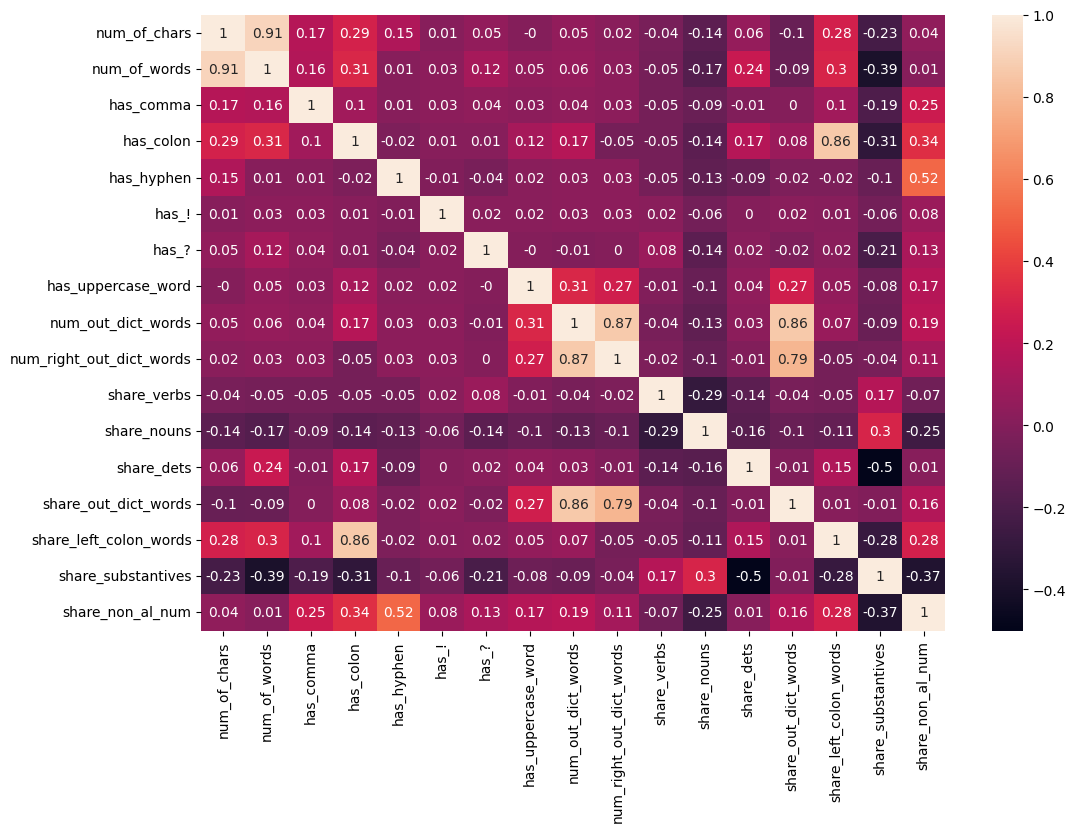

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
corr_matrix = X.corr().round(2)
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [87]:
# Correlated features:
#     1. num_of_chars, num_of_words 0.91
#     2. num_out_dict_words, num_right_out_dict_words 0.87
#     3. num_out_dict_words, share_out_dict_words 0.86
#     4. share_out_dict_words, num_right_out_dict_words 0.79

# X = X.drop(['num_of_words', 'num_right_out_dict_words', 'share_out_dict_words', 'num_right_out_dict_words'], axis=1)

In [88]:
def split_data(X, y, rd_state):
    # split training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rd_state)
#     # get True and False classes numbers
#     test_true = len(y_test[y_test == True])
#     test_false = len(y_test[y_test == False])
#     print(f"Number of True in test data: {test_true}, Number of False in test data: {test_false}")
    return X_train, X_test, y_train, y_test

In [89]:
def model_evaluation(model, X_train, y_train, X_test, y_test):
    model = model.fit(X_train, y_train)
    # training accuraccy
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    if isinstance(y_train_pred[0], float):
        y_train_pred = [0 if x < 0.5 else 1 for x in y_train_pred]
        y_test_pred = [0 if x < 0.5 else 1 for x in y_test_pred]
    train_acc = accuracy_score(y_train, y_train_pred)      
    test_acc = accuracy_score(y_test, y_test_pred)
    # precision recall fscore support
    prec_rec_fs_supp = precision_recall_fscore_support(y_test, y_test_pred, average=None, labels=[True, False])
    # AUC metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, pos_label=1)
    auc_value = {auc(fpr, tpr)}
    return train_acc, test_acc, auc_value, prec_rec_fs_supp

In [90]:
def print_evaluation(train_acc, test_acc, auc_value, prec_rec_fs_supp):
    precision, recall, f_score, support = prec_rec_fs_supp
    print(f'Training accuracy: {train_acc}')
    print(f'Test accuracy: {test_acc}')
    print(f'AUC: {auc_value}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F-score: {f_score}')
    print(f'Support: {support}')

In [91]:
# MAX_DEPTH = 11
# test_acc_threshold = 0.58
# cls_model = 'rf'
# filename = f"results/model_scores_{cls_model}_{MAX_DEPTH}_{test_acc_threshold}.txt"
# with open(filename, 'w') as f:
#     max_train_acc = 0
#     max_test_acc = 0
#     for split_state in range(100):
#         for model_state in range(100):
#             X_train, X_test, y_train, y_test = split_data(X, y, split_state)            
#             if cls_model == 'rf':
#                 cls = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=model_state)
#             elif cls_model == 'dt':
#                 cls = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=model_state)
#             elif cls_model == 'lr':
#                 cls = LogisticRegression(random_state=model_state)      
#             train_acc, test_acc, auc_value, prec_rec_fs_supp = model_evaluation(cls, X_train, y_train, X_test, y_test)
#             precision, recall, f_score, support = prec_rec_fs_supp
            
#             if train_acc > test_acc and test_acc > max_test_acc:       
#                 max_train_acc = train_acc
#                 max_test_acc = test_acc
#                 max_test_auc = auc_value
#                 max_split_state = split_state
#                 max_model_state = model_state
#             if test_acc > test_acc_threshold:
#                 f.write(f'--------------------------\n')
#                 f.write(f'split_state: {split_state}\n')
#                 f.write(f'model_state: {model_state}\n')
#                 f.write(f'Training accuracy: {train_acc}\n')
#                 f.write(f'Test accuracy: {test_acc}\n')
#                 f.write(f'AUC: {auc_value}\n')
#                 f.write(f'Precision: {precision}\n')
#                 f.write(f'Recall: {recall}\n')
#                 f.write(f'F-score: {f_score}\n')
#                 f.write(f'Support: {support}\n')
#     f.write(f'-------Final Results----------\n')
#     f.write(f'max_train_acc: {max_train_acc}\n')
#     f.write(f'max_test_acc: {max_test_acc}\n')
#     f.write(f'max_test_auc: {max_test_auc}\n')
#     f.write(f'max_split_state: {max_split_state}\n')
#     f.write(f'max_model_state: {max_model_state}\n')

## Logistic Regression

In [92]:
# X_train, X_test, y_train, y_test = split_data(X, y, 10)
# lr = LogisticRegression(random_state=30)
# lr = lr.fit(X_train, y_train)
# train_acc, test_acc, auc_value, prec_rec_fs_supp = model_evaluation(lr, X_train, y_train, X_test, y_test)

## Decision Tree

In [93]:
# DT data pipeline
X_train, X_test, y_train, y_test = split_data(X, y, 53) # best split state 53
dt = DecisionTreeClassifier(max_depth=10, random_state=1)  # best model state 1
dt = dt.fit(X_train, y_train)
train_acc, test_acc, auc_value, prec_rec_fs_supp = model_evaluation(dt, X_train, y_train, X_test, y_test)

In [94]:
# feature importance for DT
features_importance_dict = {}
feat_importance = dt.tree_.compute_feature_importances(normalize=False)
for i, feat_value in enumerate(feat_importance):
    feature = X_train.columns[i]
    features_importance_dict[feature] = feat_value
features_importance_dict.get

sorted_dict = {}
sorted_keys = sorted(features_importance_dict, key=features_importance_dict.get, reverse=True)

for w in sorted_keys:
    sorted_dict[w] = features_importance_dict[w]
sorted_dict

{'num_of_chars': 0.009027985487061857,
 'share_non_al_num': 0.008578851436325302,
 'share_nouns': 0.0068669309349366795,
 'share_substantives': 0.004962923681014551,
 'share_verbs': 0.0038710016525634293,
 'num_of_words': 0.003652418855377559,
 'share_dets': 0.003327507386616814,
 'share_left_colon_words': 0.0030346993134202317,
 'share_out_dict_words': 0.0018791113683989495,
 'has_uppercase_word': 0.0008067974238932125,
 'num_out_dict_words': 0.0005036129671264034,
 'has_hyphen': 0.00036034983566659266,
 'has_?': 0.0002964252627690065,
 'num_right_out_dict_words': 0.00025829575255979423,
 'has_colon': 0.00017085095506807089,
 'has_comma': 0.0,
 'has_!': 0.0}

In [95]:
# fig = plt.figure(figsize=(25,20))
# tree.plot_tree(dt, filled=True)
# plt.show()

In [96]:
# fig.savefig("images/decistion_tree.png")

## Random Forest

In [97]:
# # RF data pipeline (split state 9 and model state 85 for depth 15)
# X_train, X_test, y_train, y_test = split_data(X, y, 9) # best split state 45
# rf = RandomForestClassifier(max_depth=10, random_state=0) # best model state 63
# rf = rf.fit(X_train, y_train)
# train_acc, test_acc, auc_value, prec_rec_fs_supp = model_evaluation(rf, X_train, y_train, X_test, y_test)
# print_evaluation(train_acc, test_acc, auc_value, prec_rec_fs_supp)

In [98]:
# # feature importance for RF
# features_importance_dict = {}
# feat_importance = rf.feature_importances_
# for i, feat_value in enumerate(feat_importance):
#     feature = X_train.columns[i]
#     features_importance_dict[feature] = feat_value
# features_importance_dict.get

# sorted_dict = {}
# sorted_keys = sorted(features_importance_dict, key=features_importance_dict.get, reverse=True)

# for w in sorted_keys:
#     sorted_dict[w] = features_importance_dict[w]
# sorted_dict

In [99]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(
    max_depth=10,
    n_estimators=8,
    learning_rate=0.1
)
regressor = regressor.fit(X_train, y_train)
train_acc, test_acc, auc_value, prec_rec_fs_supp = model_evaluation(regressor, X_train, y_train, X_test, y_test)
print_evaluation(train_acc, test_acc, auc_value, prec_rec_fs_supp)

Training accuracy: 0.6877238908790301
Test accuracy: 0.5318269495728851
AUC: {0.5200831121984213}
Precision: [0.54173107 0.50720461]
Recall: [0.73211488 0.30805134]
F-score: [0.62269598 0.38330309]
Support: [1915 1714]


## Neural Network

In [100]:
# X_train_np = np.asarray(X_train).astype('float32')
# X_test_np = np.asarray(X_test).astype('float32')
# num_columns = len(X_train.columns)
# num_columns

In [101]:
# # build model
# model = tf.keras.models.Sequential()
# model.add(Input(shape=(num_columns,)))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='softmax'))

# # compile
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.000000001)
# METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Recall(name='AUC')]
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=METRICS)
# model.summary()

In [102]:
# # train model
# from keras.callbacks import EarlyStopping
# history = model.fit(X_train_np, y_train, epochs=10, batch_size=32,
#                     callbacks=[EarlyStopping(monitor='loss', patience=5, min_delta=0.0001)])

In [103]:
# # test model
# score, acc, prec, rec, auc = model.evaluate(X_test_np, y_test)
# print('Test score:', score)
# print('Test accuracy:', acc)
# print('Test precision:', prec)
# print('Test recall:', rec)
# print('Test auc:', auc)

## Evaluation and Feedback

In [104]:
from sentence_transformers import SentenceTransformer
model_sent = SentenceTransformer('all-MiniLM-L6-v2')

import pickle
titles_embeddings = pickle.load(open("embeddings/bert_titles_embeddings_00-17.p", "rb"))

titles = [
    "The application of Computational Creativity evaluation methods to art and music-based systems",
    "Generation or Creativity",
    "Therapeutic Computational Creativity",
    "The compusss willey return too good matttere rendr",
    "Human-Computer Evaluation: Inverting the co-creative paradigm",
]

titles_list = papers['paper_title']

model_sent.encode(titles)

array([[ 0.00506775,  0.03368654, -0.06352831, ...,  0.03594333,
         0.04712013, -0.00651115],
       [-0.04687794,  0.06518338, -0.03439899, ...,  0.06569624,
         0.04262172, -0.00235632],
       [ 0.01297472,  0.01627761, -0.01492921, ...,  0.124274  ,
         0.07095569, -0.03947164],
       [-0.06084778, -0.06792177,  0.04444922, ..., -0.07442529,
        -0.00352081,  0.07402814],
       [-0.01482522,  0.06905222, -0.0692187 , ...,  0.04471868,
         0.00144343, -0.03384705]], dtype=float32)

In [105]:
possible_feedbacks = {
    "typos": (0.4, "Too many out of dictionary words found in the title."),
    "two-part title": (0.2, "Try having fewer words or make your title a two-part title separated by a colon."),
    "before colon": (0.2, "Try having fewer words before the colon."),
    "short titles": (0.2, "Short titles are great if some of their words begin with the same letter or rhyme."),
}

totalweight = sum([i[0] for i in possible_feedbacks.values()])
print(totalweight)

1.0


In [106]:
class MachineEvaluator:
    def __init__(self, model, title):
        print("\n-------------------------------------------------------------------------------------")
        self.model = model
        self.title = title
        self.originality_treshold = 0.86
                
        # Quality
        self.totalweight = totalweight
        self.feedbacks = []
        self.prediction_change = 0
        self.y_pred, self.data, self.words = self.predict()
        self.create_feedbacks()
        self.prediction = self.add_expert_knowledge()
        
        # Originality
        self.similar_titles = []
        self.similarity_values = []
        self.title_embedding = model_sent.encode([title])
        self.cos_matrix = cosine_similarity(self.title_embedding, titles_embeddings)
        self.add_novelty(self.cos_matrix, [title], titles_list, self.originality_treshold)
        self.quality, self.originality, self.creativity = self.compute_creativity()

#     def testing_ground(self):
#         if self.words[0][-1] == self.words[1][-1]:
#             print(self.words[0][0])
        
    def predict(self):  
        data, words = process_title(self.title)
        del data['paper_title']
        X = pd.DataFrame([data])
        y_pred = self.model.predict(X)
        return y_pred, data, words
    
    def create_feedbacks(self):
        if self.data['num_out_dict_words'] >= 2:
            self.feedbacks.append(possible_feedbacks["typos"])
            # change prediction to False in case they are too many unknown words
            if self.y_pred == True:
                self.y_pred = False
                self.prediction_change = "Prediction changed from True to False b/c of typos."
                
        if self.data['num_of_chars'] > GOOD_PAPER_LENGTH and self.data['has_colon'] == False:
            self.feedbacks.append(possible_feedbacks["two-part title"])

        if self.data['share_left_colon_words'] >= 0.5:
            self.feedbacks.append(possible_feedbacks["before colon"])

#         if self.data['%_verbs'] == 0 and self.data['num_of_chars'] > 50:
#             self.feedbacks.append(possible_feedbacks["verb"])

#         if self.data['has_creativ'] == False and self.data['num_of_chars'] > 30:
#                 self.feedbacks.append('Try including a word like creativity, creative or creators in your title.')

        if self.data['num_of_words'] < 5:
            first_letters, last_letters = [], []
            for i in range(len(self.words)):
                first_letters.append(self.words[i][0])
                last_letters.append(self.words[i][-1])
            max_first_letters_count = 0
            for i, letter in enumerate(first_letters):
                first_letters_count = first_letters.count(first_letters[i][0])
                if first_letters_count > max_first_letters_count:
                    max_first_letters_count = first_letters_count
            max_last_letters_count = 0
            for i, letter in enumerate(last_letters):
                last_letters_count = last_letters.count(last_letters[i][-1])
                if last_letters_count > max_last_letters_count:
                    max_last_letters_count = last_letters_count
            if max_first_letters_count <  2 and max_last_letters_count < 2:
                self.feedbacks.append(possible_feedbacks["short titles"])
            
        random.shuffle(self.feedbacks)

    def add_expert_knowledge(self):
        # change prediction to True if no feedback is present
        if len(self.feedbacks) == 0 and self.y_pred == False:
            self.prediction_change = "Prediction changed from False to True b/c no feedback is present."
            self.y_pred = True
        if len(self.feedbacks) > 0 and self.y_pred == True:
            self.prediction_change = "Prediction changed from True to False b/c feedback is present."
            self.y_pred = False   
        if self.y_pred == False:
            prediction = f'\nYour paper will likely have LESS than {CUT_OFF} citations.'
        else:
            prediction = f'\nYour paper will likely have MORE than {CUT_OFF} citations.'
        return prediction

    def add_novelty(self, cos_matrix, sent_list1, sent_list2, treshold):
        indexes = np.where(cos_matrix > treshold)
        coord_list = list(zip(indexes[0], indexes[1]))
        for cord in coord_list:
            sent_embd_value = cos_matrix[cord]
            self.similarity_values.append(sent_embd_value)
            similar_sent = sent_list2[cord[1]]
            self.similar_titles.append(f"{similar_sent} ({100*sent_embd_value:.2f}%)")
            
    def compute_creativity(self):
        
        # quality measure
        feedbacks_weights = [i[0] for i in self.feedbacks]
        q = 1 - sum(feedbacks_weights)/self.totalweight
        
        # originality measure
        num_similarities = len(self.similarity_values)
        o = 1/(1 + num_similarities)
        
        # creativity score
        if o == 1 or q == 1:
            c = (o + q)/2
        else:
            c = o*q/(o*q + (1-o)*(1-q))
        return q, o, c

In [107]:
def print_results(eva):
    # print(f"\n{eva.data}\n")
    print("- - - - - -")
    print(f"Title: {eva.title}")

    print(f'\nOriginality:')
    print("------------")
    print(f"Your originality score is {eva.originality}.")
    if len(eva.similar_titles) != 0:
        print(f"Your title is similar to the following paper titles with corresponding similarity percentages in parentheses:\n")
        for i, similar_title in enumerate(eva.similar_titles):
            print(f'- {similar_title}\n')
    else:
        print("No similar titles present in the database.\n")


    print(f"\nQuality:")
    print("--------")
    print(f"Your quality score is {eva.quality}.")
    if len(eva.feedbacks) != 0:
        for i, feedback in enumerate(eva.feedbacks):
            print(f'- {feedback[1]}')
    else:
        print("No quality improvement feedback suggested.")

    if eva.prediction_change != 0:
        print(f"{eva.prediction_change}")
    print(f'{eva.prediction}\n')

    print("\nFinal recommendation:")
    print("--------------------")
    if eva.quality == 1 and eva.originality == 1:
        final = f'Your paper title looks GREAT!'
#         elif eva.quality < 1 and eva.quality > 0.9:
#             final = f'Your paper title looks GOOD, though some improvement may need to be considered!'
    elif eva.quality < 1 or eva.originality < 1:
        final = 'Your paper title needs some improvement.'
    print(f'Your final score is {eva.creativity}. {final}')

In [50]:
def aggregate_results(titles):
    for title in titles:
        evaluator = MachineEvaluator(rf, title)
        print_results(evaluator)

In [51]:
titles = [
    "The application of Computational Creativity evaluation methods to art and music-based systems",
    "Generation or Creativity",
    "Therapeutic Computational Creativity",
    "The compusss willey return too good matttere rendr",
    "Human-Computer Evaluation: Inverting the co-creative paradigm",
]

# random forest evaluator
aggregate_results(titles)


-------------------------------------------------------------------------------------
- - - - - -
Title: The application of Computational Creativity evaluation methods to art and music-based systems

Originality:
------------
Your originality score is 1.0.
No similar titles present in the database.


Quality:
--------
Your quality score is 0.8.
- Try having fewer words or make your title a two-part title separated by a colon.

Your paper will likely have LESS than 10 citations.


Final recommendation:
--------------------
Your final score is 0.9. Your paper title needs some improvement.

-------------------------------------------------------------------------------------
- - - - - -
Title: Generation or Creativity

Originality:
------------
Your originality score is 1.0.
No similar titles present in the database.


Quality:
--------
Your quality score is 0.8.
- Short titles are great if some of their words begin with the same letter or rhyme.
Prediction changed from True to False b/c

In [52]:
titles = [
    "Inverting the co-creative paradigm by having machines provide feedback on user generated content",
    "Inverting the co-creative paradigm by having machines evaluate us: Creative Evaluators",
    "Creative Evaluators: When Machines Evaluate Us",
]

# random forest evaluator
aggregate_results(titles)


-------------------------------------------------------------------------------------
- - - - - -
Title: Inverting the co-creative paradigm by having machines provide feedback on user generated content

Originality:
------------
Your originality score is 1.0.
No similar titles present in the database.


Quality:
--------
Your quality score is 0.8.
- Try having fewer words or make your title a two-part title separated by a colon.

Your paper will likely have LESS than 10 citations.


Final recommendation:
--------------------
Your final score is 0.9. Your paper title needs some improvement.

-------------------------------------------------------------------------------------
- - - - - -
Title: Inverting the co-creative paradigm by having machines evaluate us: Creative Evaluators

Originality:
------------
Your originality score is 1.0.
No similar titles present in the database.


Quality:
--------
Your quality score is 0.8.
- Try having fewer words before the colon.

Your paper will l

In [53]:
titles = [
    "Computational creativity via assisted variational synthesis of mechanisms using deep generative models",
    "To cluster, or not to cluster",
    "Weighted clustering",
    "Incremental clustering: The case for extra clusters",
    "Teaching computational creativity",
    "What makes a ‘good’ title and (how) does it matter for citations? A review and general model of article title attributes in management science",
    "The compusss willey return too good matttere rendr",
]

# random forest evaluator
aggregate_results(titles)


-------------------------------------------------------------------------------------
- - - - - -
Title: Computational creativity via assisted variational synthesis of mechanisms using deep generative models

Originality:
------------
Your originality score is 1.0.
No similar titles present in the database.


Quality:
--------
Your quality score is 0.8.
- Try having fewer words or make your title a two-part title separated by a colon.
Prediction changed from True to False b/c feedback is present.

Your paper will likely have LESS than 10 citations.


Final recommendation:
--------------------
Your final score is 0.9. Your paper title needs some improvement.

-------------------------------------------------------------------------------------
- - - - - -
Title: To cluster, or not to cluster

Originality:
------------
Your originality score is 1.0.
No similar titles present in the database.


Quality:
--------
Your quality score is 1.0.
No quality improvement feedback suggested.

Your 

In [54]:
titles = [
    "The application of Computational Creativity evaluation methods to music-based systems",
    "Generation or Creativity",
    "Therapeutic Computational Creativity",
    "The compusss willey return too good matttere rendr",
    "Human-Computer Evaluation: Inverting the co-creative paradigm",
]

# random forest evaluator
aggregate_results(titles)


-------------------------------------------------------------------------------------
- - - - - -
Title: The application of Computational Creativity evaluation methods to music-based systems

Originality:
------------
Your originality score is 1.0.
No similar titles present in the database.


Quality:
--------
Your quality score is 0.8.
- Try having fewer words or make your title a two-part title separated by a colon.
Prediction changed from True to False b/c feedback is present.

Your paper will likely have LESS than 10 citations.


Final recommendation:
--------------------
Your final score is 0.9. Your paper title needs some improvement.

-------------------------------------------------------------------------------------
- - - - - -
Title: Generation or Creativity

Originality:
------------
Your originality score is 1.0.
No similar titles present in the database.


Quality:
--------
Your quality score is 0.8.
- Short titles are great if some of their words begin with the same let